# Breaking Certified Defences with Shadow Attack
Breaking Certified Defences with Shadow Attack

In [1]:
import sys
sys.path.append('./models/BreakingCertifiableDefenses/RandomizedSmoothing')
from archs.cifar_resnet import resnet as resnet_cifar

from art.attacks.evasion import ShadowAttack
from art.estimators.certification.randomized_smoothing import PyTorchRandomizedSmoothing
from art.utils import load_dataset

import torch
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
device = 'cpu'
nb_classes = 10
noise_levels = [0.12, 0.25, 0.5, 1.0]

In [3]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_dataset('cifar10')
x_train = x_train.transpose((0, 3, 1, 2)).astype(np.float32)
x_test = x_test.transpose((0, 3, 1, 2)).astype(np.float32)

In [4]:
input_shape = x_train.shape[1:]
clip_values = (min_pixel_value, max_pixel_value)

In [5]:
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STDDEV = [0.2023, 0.1994, 0.2010]

preprocessing = (np.array(CIFAR10_MEAN).reshape((1, 3, 1, 1)),
                 np.array(CIFAR10_STDDEV).reshape((1, 3, 1, 1)))

In [6]:
loss = torch.nn.CrossEntropyLoss()

In [7]:
ART_mean_benign = []
ART_std_benign = []
ART_mean_adv = []
ART_std_adv = []

for noise in noise_levels:
    
    print('{0:.2f}'.format(noise))
    
    checkpoint = torch.load('./models/cifar10/resnet110/noise_{0:.2f}/checkpoint.pth.tar'.format(noise),
                            map_location=torch.device('cpu'))
    model = resnet_cifar(depth=110, num_classes=nb_classes).to(device)

    model = torch.nn.Sequential(torch.nn.Sequential(), model)
    model.load_state_dict(checkpoint['state_dict'])
    
    certified_classifier = PyTorchRandomizedSmoothing(model=model,
                                                  loss=loss,
                                                  input_shape=input_shape,
                                                  nb_classes=nb_classes,
                                                  optimizer=None,
                                                  channel_index=1,
                                                  clip_values=clip_values,
                                                  preprocessing_defences=None,
                                                  postprocessing_defences=None,
                                                  preprocessing=preprocessing,
                                                  device_type="cpu",
                                                  sample_size=100,
                                                  scale=noise,
                                                  alpha=0.001,)
    
#     attack = ShadowAttack(estimator=certified_classifier,
#                           sigma=noise,
#                           batch_size=32,
#                           nb_steps=3,
#                           learning_rate=0.00001,
#                           lambda_tv=0.1,
#                           lambda_c=20.0,
#                           lambda_s=10.0)
    
#     x_adv = attack.generate(x=x_train[0:10], y=y_train[0:10])
    
    prediction, radius = certified_classifier.certify(x_test[0:100], n=10)
    
#     getCertAcc(radius_0, prediction_0, y_test)
    
#     # Calculate certification accuracy for a given radius
#     def getCertAcc(radius, pred, y_test):

#         rad_list = np.linspace(0, 2.25, 201)
#         cert_acc = []
#         num_cert = len(np.where(radius > 0)[0])

#         for r in rad_list:
#             rad_idx = np.where(radius > r)[0]
#             y_test_subset = y_test[rad_idx]
#             cert_acc.append(np.sum(pred[rad_idx] == np.argmax(y_test_subset, axis=1)) / num_cert)

#         return cert_acc
    
    ART_mean_benign.append(np.mean(radius))
    ART_std_benign.append(np.std(radius))

0.12
0.25
0.50
1.00


In [8]:
Ghiasi_et_al_mean_benign = [0.14, 0.3, 0.47, 0.78]
Ghiasi_et_al_mean_adv = [0.22, 0.35, 0.65, 0.85]

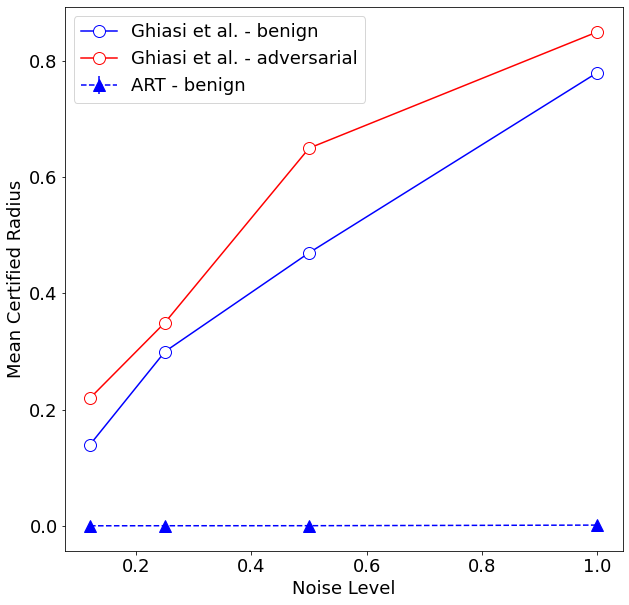

In [32]:
plt.plot(noise_levels, Ghiasi_et_al_mean_benign, marker='o', markersize=12, markerfacecolor='white',
         color='blue', label='Ghiasi et al. - benign')
plt.plot(noise_levels, Ghiasi_et_al_mean_adv, marker='o', markersize=12, markerfacecolor='white',
         color='red', label='Ghiasi et al. - adversarial')
plt.errorbar(noise_levels, ART_mean_benign, yerr=ART_std_benign, marker='^', markersize=12,
             color='blue', linestyle='--', label='ART - benign')
# plt.errorbar(noise_levels, ART_mean_adv, yerr=ART_std_adv, marker='o', markersize=12,
#              color='green', linestyle='--', label='ART - adversarial')
plt.legend(prop={'size': 18})
plt.xlabel('Noise Level', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Mean Certified Radius', fontsize=18)
plt.yticks(fontsize=18);